Importing libraries and packages

In [ ]:
!pip install tensorflow==1.4.0

In [ ]:
import numpy as np
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt

import math, time
from math import sqrt
import itertools
import sklearn
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from operator import itemgetter

import tensorflow as tf
from tensorflow.python.framework import ops
import h5py
import requests

import os
import io

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or 

#Loading the dataset

In [ ]:
#upload csv the other way with jupyter notebook
from google.colab import files
stockPricesData = files.upload()

prices_df = pd.read_csv(io.BytesIO(stockPricesData['stock_prices.csv']))

Saving stock_prices.csv to stock_prices (1).csv


In [ ]:
prices_df.info()
prices_df.head(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0
5,2016-01-12,WLTW,115.510002,115.550003,114.500000,116.059998,1098000.0


In [ ]:
#making a list of symbols
tikr = list(set(prices_df.symbol))
len(tikr)

501

#Normalizing
Normalizing for faster convergence on learning and more uniform influence for all weights. The range is set from -1 to 1, since there are negative values in the data as well.

In [ ]:
def normalize_data(prices_df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    prices_df['open'] = min_max_scaler.fit_transform(prices_df.open.values.reshape(-1,1))
    prices_df['high'] = min_max_scaler.fit_transform(prices_df.high.values.reshape(-1,1))
    prices_df['low'] = min_max_scaler.fit_transform(prices_df.low.values.reshape(-1,1))
    prices_df['close'] = min_max_scaler.fit_transform(prices_df['close'].values.reshape(-1,1))
    return prices_df
prices_df = normalize_data(prices_df)
prices_df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,0.076934,0.078812,0.078020,0.077818,2163600.0
1,2016-01-06,WLTW,0.078078,0.075095,0.076490,0.077374,2386400.0
2,2016-01-07,WLTW,0.072480,0.071904,0.073254,0.073747,2489500.0
3,2016-01-08,WLTW,0.071911,0.072964,0.072331,0.072309,2006300.0
4,2016-01-11,WLTW,0.072878,0.071917,0.072712,0.072240,1408600.0


#Creating test and train datasets

In [ ]:
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

In [ ]:
def load_data(stock, seq_len):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

#choosing the Amazon stock for split
df_stock = prices_df[prices_df.symbol == 'AMZN'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)
df_stock.drop(['date'],1,inplace=True)


cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

df_stock.columns.values =  ['open', 'close', 'low', 'high']
x_train.shape =  (1394, 19, 4)
y_train.shape =  (1394, 4)
x_valid.shape =  (174, 19, 4)
y_valid.shape =  (174, 4)
x_test.shape =  (174, 19, 4)
y_test.shape =  (174, 4)


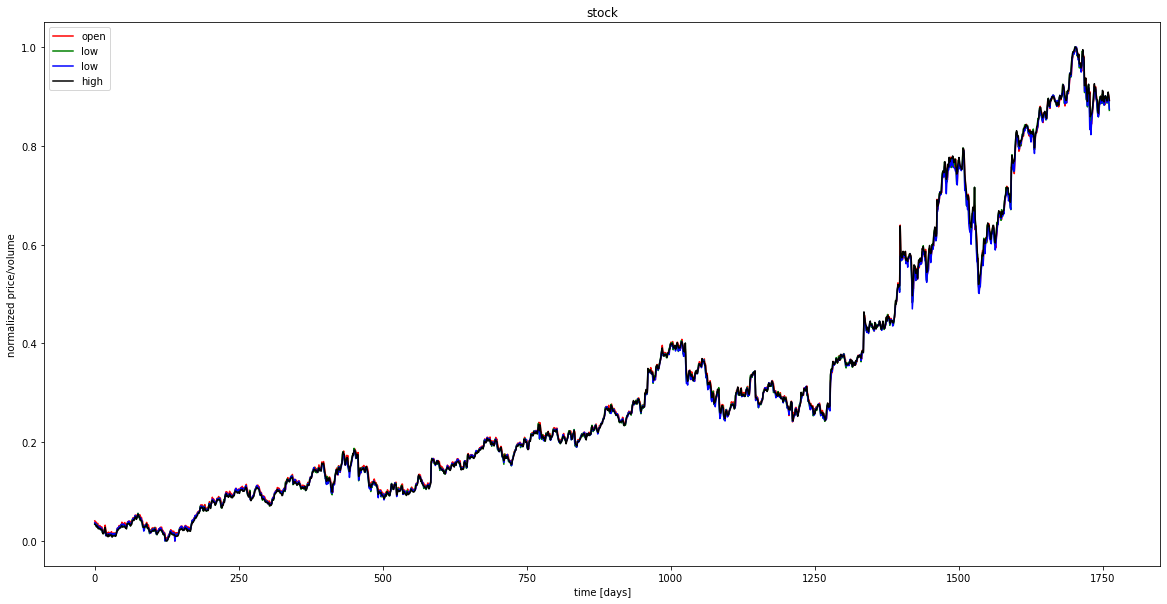

In [ ]:
#plotting a graph to see the trends of Amazon normalized data
plt.figure(figsize=(20, 10));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')

plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

In [ ]:
df_stock_norm.head(5)

,open,close,low,high
284,0.040981,0.034373,0.037207,0.034406
751,0.037169,0.035447,0.035397,0.032870
1219,0.038751,0.032130,0.035180,0.031851
1687,0.035250,0.029072,0.031301,0.028576
2155,0.033290,0.033857,0.031614,0.030424


#Modeling the data

In [ ]:
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

ops.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]


#Training and Validation

In [ ]:
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

0.00 epochs: MSE train/valid = 0.028227/0.234123
4.99 epochs: MSE train/valid = 0.000205/0.001398
9.97 epochs: MSE train/valid = 0.000177/0.001595
14.96 epochs: MSE train/valid = 0.000147/0.000989
19.94 epochs: MSE train/valid = 0.000141/0.000906
24.93 epochs: MSE train/valid = 0.000120/0.000733
29.91 epochs: MSE train/valid = 0.000115/0.001030
34.90 epochs: MSE train/valid = 0.000108/0.000654
39.89 epochs: MSE train/valid = 0.000107/0.000594
44.87 epochs: MSE train/valid = 0.000086/0.000542
49.86 epochs: MSE train/valid = 0.000079/0.000416
54.84 epochs: MSE train/valid = 0.000074/0.000382
59.83 epochs: MSE train/valid = 0.000077/0.000499
64.81 epochs: MSE train/valid = 0.000070/0.000300
69.80 epochs: MSE train/valid = 0.000065/0.000302
74.78 epochs: MSE train/valid = 0.000059/0.000287
79.77 epochs: MSE train/valid = 0.000058/0.000258
84.76 epochs: MSE train/valid = 0.000056/0.000245
89.74 epochs: MSE train/valid = 0.000063/0.000275
94.73 epochs: MSE train/valid = 0.000059/0.000285
99.